In [475]:
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-whitegrid')

# Part A: Grab the Data

We'll start by loading the data into a dataframe:

In [476]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
train = pd.read_csv(url)

We'll take a peak at how the data looks:

In [477]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


# Part B: Explore The Data

Create at least two visualizations and one summary table in which you explore patterns in the data. You might consider some questions like:

How does loan intent vary with the age, length of employment, or homeownership status of an individual?

Which segments of prospective borrowers are offered low interest rates? Which segments are offered high interest rates?

Which segments of prospective borrowers have access to large lines of credit?

#### Summary table
The following table shows the means of each quantitative column, grouped by loan_grade, descending from the best grade 'A', denoting confidence that the recipient will pay back the loan, to the worst grade 'G', denoting the least confidence that the recipient will pay back the loan. We can see that loan as percent of income increases as the loan grade decreases. 
Loan amount increases as the loan grade decreases.
Loan interest rate increases as the loan grade decreases.

Interesting: the lower grades have a higher income.

I've selected just the columns with quantitative information and cleaned the data by removing rows with missing values.

In [478]:
quant_col = ["loan_grade", "loan_percent_income", "person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "cb_person_cred_hist_length"]
train_quant = train[quant_col].dropna()
train_quant.groupby(["loan_grade"]).aggregate("mean") #, "person_home_ownership"

,loan_percent_income,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,cb_person_cred_hist_length
loan_grade,,,,,,,
A,0.152629,27.682077,66773.007816,5.122533,8555.884885,7.338368,5.730560
B,0.173846,27.673949,66662.091096,4.750069,10031.025007,11.003273,5.766007
C,0.168928,27.792667,66416.633130,4.402663,9322.102794,13.456237,5.855303
D,0.188833,27.853112,64555.473908,4.699652,10821.646695,15.358261,5.861229
E,0.204190,27.732955,70868.349432,4.458807,12929.083807,17.047344,5.747159
F,0.220982,28.564417,80756.546012,4.239264,15395.705521,18.519018,6.214724
G,0.243409,28.181818,77342.477273,5.954545,17384.659091,20.230000,6.500000


Let's load our visualization library:

In [479]:
import seaborn as sns

#### Visualization 1

This visualization shows the effect of loan grade on loan amount in two cases - if the person defaulted on their loan or not. We can see that as the loan amount increases, the loan grade decreases. This indicates loan amount may be a good predictor variable of loan status. While a default on file doesn't have much effect on the loan amount, we can see that there are NO loans of grades A and B given to those with a default on file. This is an interesting bit of information that could definitely help predict loan status - on the other hand, it may be more of a mistrustful approach for the bank not wanting to lose money again, therefore skewing their loan grade variable. 

<Axes: xlabel='cb_person_default_on_file', ylabel='loan_amnt'>

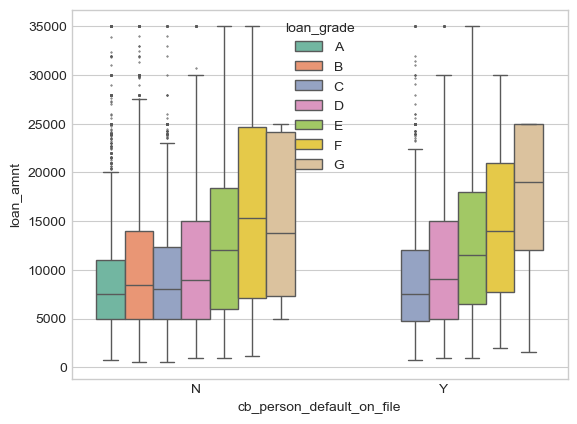

In [480]:
sns.boxplot(train, x="cb_person_default_on_file", y="loan_amnt", hue_order=["A", "B", "C", "D", "E", "F", "G"], hue="loan_grade", palette="Set2", fliersize=0.5)

#### Visualization 2

Here we visualize a scatterplot where loan percent income is on the x-axis, and loan interest rate is on the y-axis. The color of the data corresponds to the loan grade given by the bank.

We can see that loan interest rate has a high correlation to loan grade - the higher the interest rate, the lower the loan grade.

<Axes: xlabel='loan_percent_income', ylabel='loan_int_rate'>

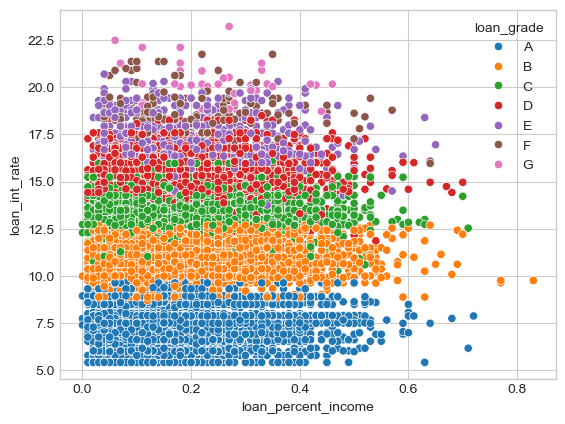

In [481]:
order_loan_grade = ["A", "B", "C", "D", "E", "F", "G"]
sns.scatterplot(train, x="loan_percent_income", y="loan_int_rate", hue="loan_grade", hue_order=order_loan_grade)

# Part C: Build a Model

We're going to use cross validation to score all combinations of features to find the best ones to use in our model.

### Data Preparation

In order to find the optimal variables for a model, we need to prep the data - specifically dropping rows with NAs and using one-hot encoding to turn the categorical variables into numerical ones.

In [482]:
train = train.dropna()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["loan_status"])

def prepare_data(df):
  y = le.transform(df["loan_status"])
  df = df.drop(["loan_status"], axis = 1)
  df = 1*pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

If we check how our data looks, we can see each categorical variable now is represented by multiple columns with binary values.

In [483]:
X_train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,27,98000,3.0,11750,13.47,0.12,6,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,22,36996,5.0,10000,7.51,0.27,4,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,24,26000,2.0,1325,12.87,0.05,4,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,29,53004,2.0,15000,9.63,0.28,10,1,0,0,...,0,1,0,0,0,0,0,0,1,0
6,21,21700,2.0,5500,14.91,0.25,2,0,0,0,...,0,0,0,0,1,0,0,0,1,0


We will use the ``combinations`` function from the ``itertools`` package. This will list all the combinations of one discreet variable and two continuous variables. Iterating through all the possible combinations, it will A) score the model using cross validation, and B) return the best combination of columns that performed the best.

In [484]:
from sklearn.linear_model import LogisticRegression
from itertools import combinations
from sklearn.model_selection import cross_val_score

LR = LogisticRegression(max_iter=999)

all_qual_cols = ["person_home_ownership", "loan_intent", "cb_person_default_on_file"]
all_quant_cols = ["person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]

score = 0
cols_best = []

for qual in all_qual_cols:
    qual_cols = [col for col in X_train.columns if qual in col]
    for pair in combinations(all_quant_cols, 2):
        cols = qual_cols + list(pair)

        #fit the models
        log_score = cross_val_score(LR, X_train[cols], y_train, cv = 5).mean()

        #compare the scores
        if log_score > score:
            score = log_score
            cols_best = cols

#output the best score, along with the corresponding columns
print(score)
print(cols_best)


0.8488229950993185
['person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'person_age', 'loan_percent_income']


Looks like the best features to use are: person_home_ownership, person_age, and loan_percent_income

In [485]:
LR = LogisticRegression(max_iter=999999999)
model = LR.fit(X_train[cols_best], y_train)

Our weights are now stored in:

In [486]:
model.coef_


array([[-7.52981385e-01, -8.75812948e-02, -1.79583155e+00,
         2.81498971e-01, -4.00881551e-03,  8.27632650e+00]])

In [487]:
X_train[cols_best]

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,person_age,loan_percent_income
1,0,0,0,1,27,0.12
2,0,0,0,1,22,0.27
3,0,0,0,1,24,0.05
4,1,0,0,0,29,0.28
6,0,0,0,1,21,0.25
...,...,...,...,...,...,...
26059,1,0,0,0,36,0.02
26060,0,0,0,1,23,0.09
26061,0,0,0,1,22,0.25
26062,1,0,0,0,30,0.24


# Part D: Find a Threshold

Once we have a weight vector **w**, it is time to choose a threshold *t*. To choose a threshold that maximizes profit for the bank, we need to make some assumptions about how the bank makes and loses money on loans. Let’s use the following (simplified) modeling assumptions:

If the loan is repaid in full, the profit for the bank is equal to 

``loan_amnt*(1 + 0.25*loan_int_rate)**10 - loan_amnt``      ( 1 )

This formula assumes that the profit earned by the bank on a 10-year loan is equal to 25% of the interest rate each year, with the other 75% of the interest going to things like salaries for the people who manage the bank. It is extremely simplistic and does not account for inflation, amortization over time, opportunity costs, etc.

If the borrower defaults on the loan, the “profit” for the bank is equal to 

``loan_amnt*(1 + 0.25*loan_int_rate)**3 - 1.7*loan_amnt``   ( 2 )

This formula corresponds to the same profit-earning mechanism as above, but assumes that the borrower defaults three years into the loan and that the bank loses 70% of the principal.
Based on your assumptions, determine the threshold *t* which optimizes profit for the bank on the training set. Explain your approach, including labeled visualizations where appropriate, and include a final estimate of the bank’s expected profit per borrower on the training set.

#### Calculate the Profit

Let's first create a function to calculate the profit from predicted target variables. It will take in the prediction column of 0s and 1s that guesses if a person will default or not, and return the total profit.

First, we have to compare our predictions to the actual loan_status to then calculate the benefit or cost. There are three possible cases: 

1. If we predict someone to default, regardless of what actually happened, we'll treat it as a 0 because we wouldn't give them a loan.
2. If we predict someone to not default - 0 - and that was actually the case - loan_status of 0, this is an instance of a **true negative**. We'll use equation 1 to calculate our profit for a fully repaid loan. 
3. If we predict someone to not default - 0 - and they actually did default - loan_status of 1, this is an instance of a **false negative**. We'll use equation 2 to calculate our profit for a defaulted loan.

In [488]:
def profit(X, y, target_col):

    num_people = y.size

    # calculate new data - 0, 1, or nan given our target_col and loan_status
    X["confusion"] = np.where(target_col == 1, np.nan, np.where((target_col == 0) & (y == 0), 0, 1))
    X.dropna()

    # use our assumptions above to calculate overall sum
    return ((X["loan_amnt"] * (1 + 0.0025*X["loan_int_rate"])**(10 - 7*X["confusion"]) - (1 + 0.7*X["confusion"])*X["loan_amnt"]).sum())/num_people

# test
profit(X_train, y_train, train["loan_status"])

2222.8525339091298

First, we'll turn our scores into a numpy array ``w`` for ease

In [489]:
w = np.array(model.coef_)[0]
w

array([-7.52981385e-01, -8.75812948e-02, -1.79583155e+00,  2.81498971e-01,
       -4.00881551e-03,  8.27632650e+00])

Let's create a function ``linear_score`` that computes the weighted score using our 6 predictor columns and weights ``w``

In [490]:
def linear_score(X, w):
    return X@w

Let's also create a predict method to guess based off of our threshold:

In [491]:
def predict(w, threshold, df):
    
    # compute the scores using weights and predictor variables
    scores = linear_score(df, w)

    # scipy's minimize function messes with the var type, so we'll fix it here
    if isinstance(threshold, np.ndarray):
        threshold = threshold.item()

    # the actual thresholding step that generates binary predictions
    return 1*(scores>threshold)

We'll use this function to add a new column into our dataframe of our predictions based off of our threshold. Let's start off with a guess of 1 as the threshold:

In [492]:
X_train["prediction"] = predict(w, 1, X_train[cols_best])

Let's see how well our guess does!

In [493]:
(X_train["prediction"] == y_train).mean()

0.6271881957480246

That reflects how accurate we were - but how about finding the profit from that threshold? That's ultimately the goal here.

In [494]:
profit(X_train, y_train, X_train["prediction"])

869.6881282011279

Nice! Looks like this would result in a profit per person of $870! Now let's calculate the optimal threshold that allows our bank to make the most profit.

Let's create a master function ``optimal`` that takes in a threshold t and returns the profit 

In [495]:
def optimal(t):
    return profit(X_train, y_train, predict(w, t, X_train[cols_best]))

# test it on a threshold of 1
print(optimal(1))

869.6881282011279


Now let's graph this function over the span of possible thresholds

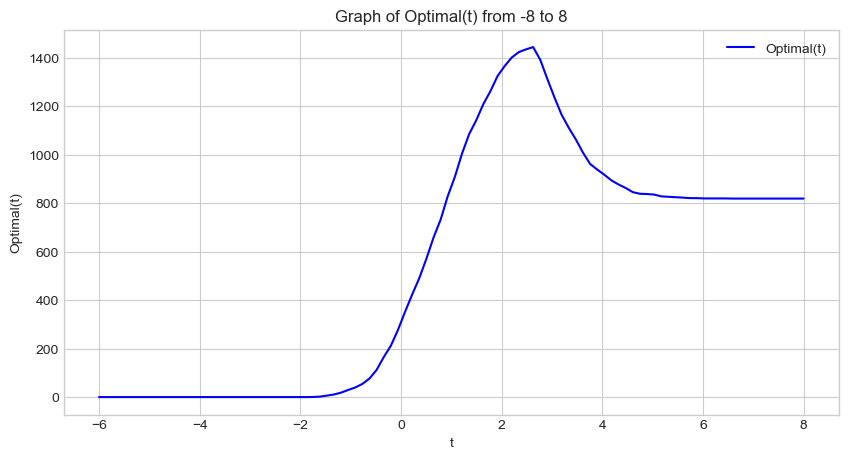

In [496]:
t_values = np.linspace(-6, 8, 100)
optimal_values = [optimal(t) for t in t_values]

# Plotting the function
plt.figure(figsize=(10, 5))
plt.plot(t_values, optimal_values, label='Optimal(t)', color='blue')
plt.title('Graph of Optimal(t) from -8 to 8')
plt.xlabel('t')
plt.ylabel('Optimal(t)')
plt.grid(True)
plt.legend()
plt.show()

Looks like there's a clear maximum for `t` somewhere in the 2-4 range

Now we'll use scipy's `minimize` method to find the optimal value for the threshold.

In [497]:
from scipy.optimize import minimize

init_threshold = 1
result = minimize(lambda t: -optimal(t), x0 = init_threshold, method='Nelder-Mead') # Nelder-Mead is a great method for non-linear functions

optimal_threshold = result.x[0]
print("Optimal threshold: ", optimal_threshold)
print("Maximum Profit: ", optimal(optimal_threshold))



Optimal threshold:  2.6687500000000033
Maximum Profit:  1445.9819108569352


We've now found our optimal threshold `t` of approximately 2.69, resulting in a profit for the bank of about $1446 per person.

# Part E: Evaluate Your Model from the Bank’s Perspective

Only after you have finalized your weight **w** vector  and threshold *t*, evaluate your automated decision-process on the test set:

In [498]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
test = pd.read_csv(url)

test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,42000,RENT,5.0,VENTURE,D,1000,15.58,1,0.02,N,4
1,32,51000,MORTGAGE,2.0,DEBTCONSOLIDATION,B,15000,11.36,0,0.29,N,9
2,35,54084,RENT,2.0,DEBTCONSOLIDATION,C,3000,12.61,0,0.06,N,6
3,28,66300,MORTGAGE,11.0,MEDICAL,D,12000,14.11,1,0.15,N,6
4,22,70550,RENT,0.0,MEDICAL,E,7000,15.88,1,0.08,N,3


Let's start by filtering to just our predictor columns and preparing the data in the same way as the train set:

In [499]:
test = test.dropna()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test["loan_status"])

def prepare_data(df):
  y = le.transform(df["loan_status"])
  df = df.drop(["loan_status"], axis = 1)
  df = 1*pd.get_dummies(df)
  return df, y

X_test, y_test = prepare_data(test)

In [500]:
X_test["prediction"] = predict(w, optimal_threshold, X_test[cols_best])
profit(test, y_test, X_test["prediction"])

1386.0022776563628

The test set yielded a profit of $1386 per person. Very close to our training numbers!

# Part F: Evaluate Your Model From the Borrower’s Perspective

Now let's evaluate the model from the perspective of the prospective borrowers. 

*Please quantitatively address the following questions, using the predictions of your model on the test data:*

#### 1. Is it more difficult for people in certain age groups to access credit under your proposed system?

To answer this, let's first create a new dataframe to plot age and our model's predictions.

In [501]:
age = test[["person_age"]]
age["prediction"] = X_test["prediction"]

# we'll create bins for age ranges
bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 100]
labels = ['20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60+']

# categorize person_age into age groups
age['age_group'] = pd.cut(test['person_age'], bins=bins, labels=labels)

/var/folders/rd/vvrhhjq53ds_4zcgxzqhtlc40000gn/T/ipykernel_46408/965901921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age["prediction"] = X_test["prediction"]
/var/folders/rd/vvrhhjq53ds_4zcgxzqhtlc40000gn/T/ipykernel_46408/965901921.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age['age_group'] = pd.cut(test['person_age'], bins=bins, labels=labels)


Then we'll plot a bar chart with age group on the x-axis and average prediction from 0-1 on the y-axis, showing how likely it is that someone in that age group will receive a loan from the bank. The lower the average prediction, the more likely they are to receive a loan.

/var/folders/rd/vvrhhjq53ds_4zcgxzqhtlc40000gn/T/ipykernel_46408/452989469.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = age.groupby('age_group')['prediction'].mean().reset_index()


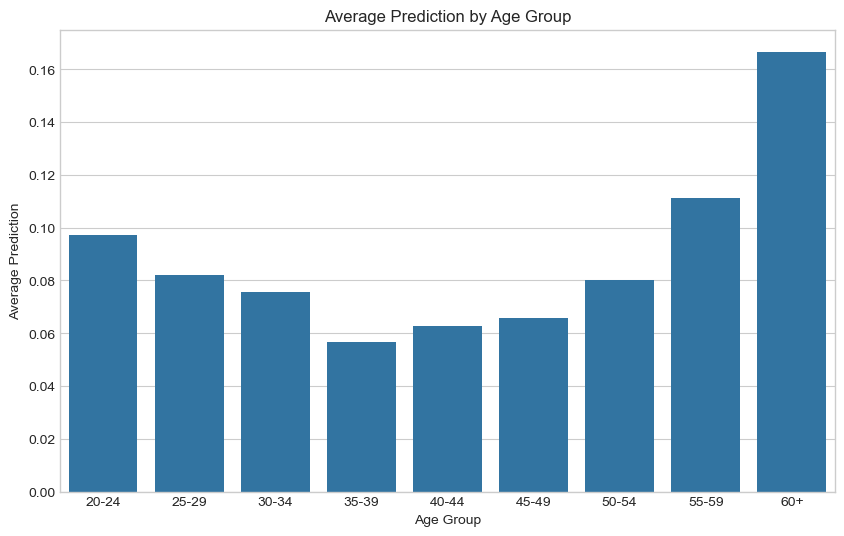

In [502]:
# calculate means for each group
group_means = age.groupby('age_group')['prediction'].mean().reset_index()

# create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='prediction', data=group_means)
plt.title('Average Prediction by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Prediction')
plt.show()

From this information, there is a clear trend where from you 20s, as you get older you are more likely to receive a loan - then after 40, you become less likely to receive a loan as you get older. In other words, the closer you are to the 35-49 range, the more likely you'll be to receive a loan. This makes sense, as that's the age people are looking for homes and cars and big purchases, while also being in the midst of a career with plenty of time to pay off the loan. Younger groups have less financial stability, and older groups have less time and income.

#### 2. Is it more difficult for people to get loans in order to pay for medical expenses? How does this compare with the actual rate of default in that group? What about people seeking loans for business ventures or education?

To answer this question, we'll do a similar approach to the last problem where we see that predicted average default, and compare it to the actual default.

In [503]:
intent = test[["loan_intent", "loan_status"]]
intent["prediction"] = X_test["prediction"]

/var/folders/rd/vvrhhjq53ds_4zcgxzqhtlc40000gn/T/ipykernel_46408/2029228914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intent["prediction"] = X_test["prediction"]


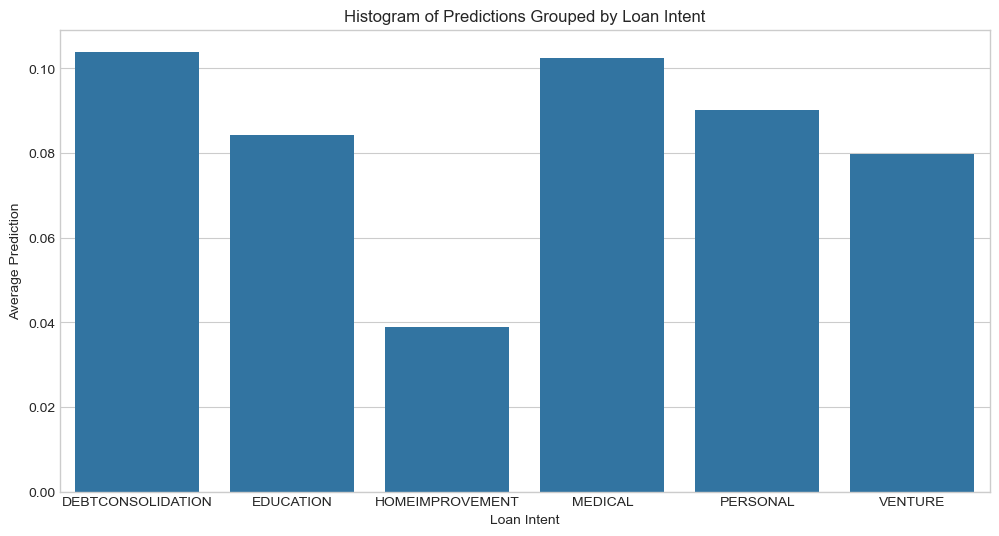

In [504]:
pred_means = intent.groupby('loan_intent')['prediction'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='loan_intent', y='prediction', data=pred_means)
plt.title('Histogram of Predictions Grouped by Loan Intent')
plt.xlabel('Loan Intent')
plt.ylabel('Average Prediction')
plt.show()

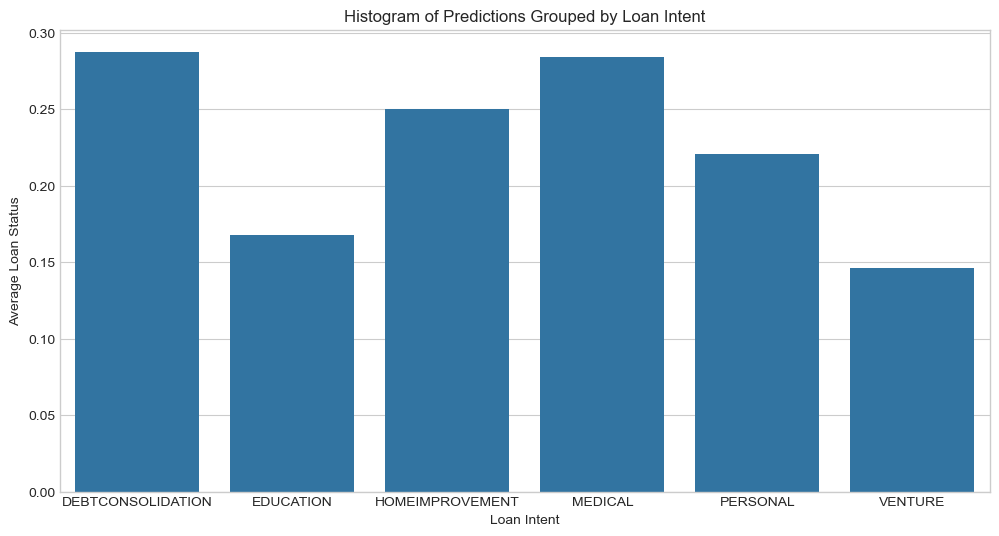

In [505]:
actual_means = intent.groupby('loan_intent')['loan_status'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='loan_intent', y='loan_status', data=actual_means)
plt.title('Histogram of Predictions Grouped by Loan Intent')
plt.xlabel('Loan Intent')
plt.ylabel('Average Loan Status')
plt.show()

In [506]:
print(pred_means)
print(actual_means)

         loan_intent  prediction
0  DEBTCONSOLIDATION    0.103982
1          EDUCATION    0.084184
2    HOMEIMPROVEMENT    0.038961
3            MEDICAL    0.102516
4           PERSONAL    0.090180
5            VENTURE    0.079876
         loan_intent  loan_status
0  DEBTCONSOLIDATION     0.287611
1          EDUCATION     0.167517
2    HOMEIMPROVEMENT     0.250000
3            MEDICAL     0.284250
4           PERSONAL     0.220441
5            VENTURE     0.146266


# REQUEST FOR FEEDBACK:

#### I'm not sure I've computed the test data correctly, as the actual default rates are much different than my predicted rates. I'd appreciate a quick check on these and if I'm computing it properly.

*

*

*

*

*

*

*

*

*

*

___________________________________________________________________________________________________________________________________________________________________________

3. How does a person’s income level impact the ease with which they can access credit under your decision system?

# Part G: Write and Reflect

Write a brief introductory paragraph for your blog post describing the overall purpose, methodology, and findings of your study. Then, write a concluding discussion describing what you found and what you learned through from this blog post.

Please include one paragraph discussing the following questions:

Considering that people seeking loans for medical expense have high rates of default, is it fair that it is more difficult for them to obtain access to credit?
You are free to define “fairness” in a way that makes sense to you, but **please write down your definition** as part of your discussion.